# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Conclusion](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import f1_score

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

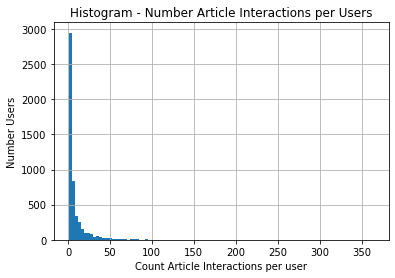


              count
count  5148.000000
mean      8.930847
std      16.802267
min       1.000000
25%       1.000000
50%       3.000000
75%       9.000000
max     364.000000


In [3]:
# df with number of articles interactions per user
user_articles_count = df.groupby("email")["article_id"].count().sort_values().reset_index(name = 'count')

# histogram with number of articles interactions per user
plt.hist(user_articles_count["count"], bins = 100)
plt.title("Histogram - Number Article Interactions per Users")
plt.xlabel('Count Article Interactions per user')
plt.ylabel('Number Users')
plt.grid(True)
plt.show()

print("\n", user_articles_count.describe())

In [4]:
# Fill in the median and maximum number of user_article interactios below
median_val = user_articles_count["count"].median() # 50% of individuals interact with ____ number of articles or fewer.
print("{} median count of artilces per user".format(median_val))

max_views_by_user = user_articles_count["count"].max() # The maximum number of user-article interactions by any 1 user is ______.
print("{} max count of artilces by one user".format(max_views_by_user))

3.0 median count of artilces per user
364 max count of artilces by one user


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [5]:
# Find and explore duplicate articles
df_content[df_content["article_id"].duplicated(keep = False)].sort_values(by = "article_id")

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [6]:
# df_content shape before dublicates removal
print("df_content shape before duplicates removal: {}".format(df_content.shape))

# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset = ["article_id"])

# df_content shape after dublicates removal
print("df_content shape after duplicates removal: {}".format(df_content.shape))

df_content shape before duplicates removal: (1056, 5)
df_content shape after duplicates removal: (1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [7]:
# The number of unique articles that have at least one interaction
unique_articles = df["article_id"].nunique()
print("{} unique articles".format(unique_articles))

# The number of unique articles on the IBM platform
total_articles = df_content["article_id"].nunique()
print("{} total articles".format(total_articles))

# The number of unique users
unique_users = df["email"].nunique() 
print("{} unique users".format(unique_users))

# The number of user-article interactions
user_article_interactions = len(df) 
print("{} user article interactions".format(user_article_interactions))

714 unique articles
1051 total articles
5148 unique users
45993 user article interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [8]:
most_viewed_article = df["article_id"].value_counts().reset_index(name = "count")

# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(most_viewed_article["index"][0]) 
print("{} most viewed article_id".format(most_viewed_article_id))

# The most viewed article in the dataset was viewed how many times?
max_views = most_viewed_article["count"][0] 
print("{} counted views of article {}".format(max_views, most_viewed_article_id))

1429.0 most viewed article_id
937 counted views of article 1429.0


In [9]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df["email"]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df["email"]
df["user_id"] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [10]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df["title"].value_counts().head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df["article_id"].value_counts().head(n).index)
 
    return top_articles # Return the top article ids

In [12]:
print(get_top_articles(10),"\n")
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model'] 

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [13]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [14]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(["user_id", "article_id"])["title"].max().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [15]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [16]:
# Store data (serialize)
with open("user_item_matrix.p", "wb") as handle:
    pickle.dump(user_item, handle, protocol = pickle.HIGHEST_PROTOCOL)

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_row = user_item.iloc[user_id - 1] # subtract 1 from user_id, as user_id starts with 1 and index with 0
    similarity = np.dot(user_row, user_item.T) # compute similarity with dot product from user_row and transversed user_item

    # sort by similarity
    sort_indices = np.argsort(-similarity) # sort array with similarity according user_id
    sort_indices += 1 # add 1 from index, as index starts with 0 and user_id with 1
   
    # create list of just the ids and remove the own user's id
    most_similar_users = list(sort_indices[1:])
       
    return most_similar_users # return a list of the users in order from most to least similar 

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 3870, 131, 46, 4201, 49]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(set(df[df["article_id"].isin(article_ids)]["title"]))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id]
    article_ids = [str(a_id) for a_id in article_ids[article_ids == 1].index]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    user_ids = find_similar_users(user_id)    
    recs = df[df["user_id"].isin(user_ids)]["article_id"]
    
    recs = list(set(recs))[:m]
    
    return recs # return your recommendations for this user_id    

In [20]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['apache spark™ 2.0: extend structured streaming for spark ml',
 'timeseries data analysis of iot events by using jupyter notebook',
 'detect malfunctioning iot sensors with streaming analytics',
 'higher-order logistic regression for large datasets',
 'data science bowl 2017',
 'this week in data science (april 18, 2017)',
 'analyze ny restaurant data using spark in dsx',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'the greatest public datasets for ai – startup grind',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object']

In [21]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [22]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    user_articles_interactions = df.groupby(["user_id"])["article_id"].count()
    
    # similarity of each user to selected user
    n_users = user_item.shape[0]
    
    # columns
    neighbor_id = [u_id for u_id in range(1, n_users) if u_id != user_id]
    similarity = []
    num_interactions = []
    
    # set similarity and num_interactions
    for u_id in neighbor_id:
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[u_id]))
        num_interactions.append(user_articles_interactions.loc[u_id])
    
    # create dataframe
    neighbors_df = pd.DataFrame({"neighbor_id": neighbor_id,
                                "similarity": similarity,
                                "num_interactions": num_interactions
                                })
    
    # sort dataframe by similarity
    neighbors_df.sort_values(by = ["similarity", "num_interactions"], ascending = False, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id)
    
    # set top-m neighbor_id
    top_m_neighbors = list(neighbors_df[:m]["neighbor_id"])
    
    # set article_ids seen by top-m neighbors
    recs = []
    for u_id in top_m_neighbors:
        article_ids = user_item.loc[u_id]
        recs.extend([str(a_id) for a_id in article_ids[article_ids == 1].index])
    
    recs = list(set(recs))[:m]
    
    # set article names and remove dublicates
    rec_names = list(set(df[df["article_id"].isin(recs)]["title"]))
    
    return recs, rec_names

In [23]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['256.0', '1314.0', '112.0', '1298.0', '761.0', '1184.0', '465.0', '981.0', '1152.0', '1330.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: venice reviews', 'healthcare python streaming application demo', 'variational auto-encoder for "frey faces" using keras', 'super fast string matching in python', 'xml2 1.0.0', 'introduction to neural networks, advantages and applications', 'from scikit-learn model to cloud with wml client', 'building custom machine learning algorithms with apache systemml', 'insights from new york car accident reports', 'city population by sex, city and city type']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [24]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id 
print("1st user which is most similar to user 1: {}\n".format(user1_most_sim))

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id 
print("10th user which is most similar to user 131: {}".format(user131_10th_sim))

1st user which is most similar to user 1: 3933

10th user which is most similar to user 131: 242


In [25]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response:**

The User-Based Collaborative Filtering Method is not applicable due to the cold start problem. We don't have data of interactions with articles from the new user and therefore calculation of similarities is not possible (because row in user_item matrix for new user has no values).
For new users we can only recommend articles using the Ranked-Based Filtering method with the function "get_top_articles".

A better way of making recommedations to new users could be with the Knowledge Based Filtering Method. Here we would need selected input informations from the user as preferences of article topics. We could use also the Content Based Filtering Method.  

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [26]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
new_user_recs = [str(id) for id in new_user_recs]

In [27]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part IV** of the notebook. 

In [28]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [29]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices = False) # use the built in to get the three matrices

In [30]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

**Response:**

We can use SVD method because the user-item matrix is completely filled with values (0 and 1). In case of one or more missing values in the matrix (None or NaN), as in the example from the lesson, SVD couldn't decomposit user-item matrix into the 3 matrices u, s, vt. Then we would need to use FunkSVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

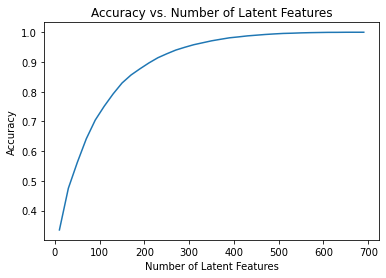

In [31]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [32]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [33]:
# How many users can we make predictions for the test set?
answer_1 = len(np.intersect1d(user_item_test.index, user_item_train.index))
print("{} number of users in test set we can make predictions for".format(answer_1))

# How many users in the test set are we not able to make predictions for because of the cold start problem?
answer_2 = len(set(user_item_test.index) - set(user_item_train.index))
print("{} number of users in test set we can NOT make predictions for (cold start problem)".format(answer_2))

# How many articles can we make predictions for in the test set?
answer_3 = len(np.intersect1d(user_item_test.columns, user_item_train.columns))
print("{} number of articles in test set we can make predictions for".format(answer_3))

# How many articles in the test set are we not able to make predictions for because of the cold start problem?
answer_4 = len(set(user_item_test.columns) - set(user_item_train.columns))
print("{} number of articles in test set we can NOT make predictions for (cold start problem)".format(answer_4))

20 number of users in test set we can make predictions for
662 number of users in test set we can NOT make predictions for (cold start problem)
574 number of articles in test set we can make predictions for
0 number of articles in test set we can NOT make predictions for (cold start problem)


In [34]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': answer_1, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': answer_2, 
    'How many articles can we make predictions for in the test set?': answer_3,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': answer_4
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [35]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices = False) # fit svd similar to above then use the cells below

u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [36]:
# find subset of user and article matrices which could be calculated with dot product
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

u_test.shape, vt_test.shape

((20, 714), (714, 574))

In [37]:
# find the subset of users and articles from user_item_test that be could predict.
test_users = np.intersect1d(user_item_train.index, user_item_test.index)
test_articles = np.intersect1d(user_item_train.columns, user_item_test.columns)
user_item_test_pred = user_item_test.loc[test_users, test_articles]

In [38]:
num_latent_feats = np.arange(10,700+10,20)

sum_errs_train = []
sum_errs_test = []

f1_train = []
f1_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_pred, user_item_test_est)
    
    # total errors and keep track of them
    errs_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(errs_train)
    errs_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(errs_test)
    
    # compute denominators for accuracy score
    denom_acc_train = user_item_train_est.shape[0] * user_item_train_est.shape[1]
    denom_acc_test = user_item_test_est.shape[0] * user_item_test_est.shape[1]
    
    # compute f1 score (macro) for each prediction
    f1_train.append(f1_score(np.array(user_item_train).flatten(), user_item_train_est.flatten(), labels=[1.0], average='macro'))
    f1_test.append(f1_score(np.array(user_item_test_pred).flatten(), user_item_test_est.flatten(), labels=[1.0], average='macro'))

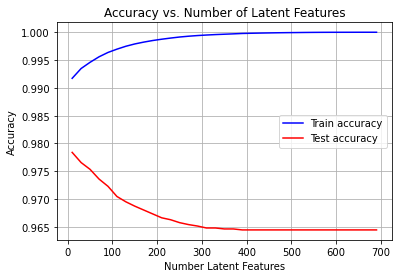

In [39]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/denom_acc_train, c = "b", label = "Train accuracy")
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/denom_acc_test, c = "r", label = "Test accuracy")
plt.title('Accuracy vs. Number of Latent Features')
plt.xlabel('Number Latent Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

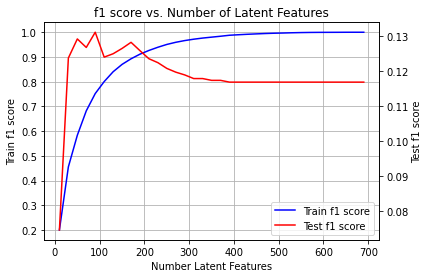

In [40]:
fig, ax_train = plt.subplots()
ax_test = ax_train.twinx()

f1_train_plot, = ax_train.plot(num_latent_feats, f1_train, c = "b", label = "Train f1 score")
f1_test_plot, = ax_test.plot(num_latent_feats, f1_test, c = "r", label = "Test f1 score")
ax_train.set_title("f1 score vs. Number of Latent Features")
ax_train.set_xlabel("Number Latent Features")
ax_train.set_ylabel("Train f1 score")
ax_test.set_ylabel("Test f1 score")
ax_train.grid(True)

lines = [f1_train_plot, f1_test_plot]
ax_train.legend(lines, [l.get_label() for l in lines])
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Response:**

Train accuracy is increasing with higher number of latent features while test accuracy is decreasing.

In the data set we have only 20 users in train and test set we can make predictions for. Furthermore there are many zeros in the user-item matrix showing that users were not active in many times. In short we have an imbalanced distribution with few interactions and the accuracy is not a good metric to evaluate the performance of the recommendations. In this case the f1 score is a better evaluation metric.

The f1 score for the test set increases to a maximum peak at appr. 100 latent features and then decreases. The decline after the peak indicates that the model gets more and more overfitted with higher number of latent features when performing matrix factorization.

One possible evaluation metric for our recommender system would be an A/B test. We would split users into two groups (control & experiment). In the control group we would recommend articles with the Ranked-Based Recommendation method while in the experiment group we would recommend articles using the Matrix Factorization method. Thus we could check if we could increase user engagement on IBM Watson Studio platform with this metric.

### <a class="anchor" id="conclusions">Part V: Extras & Conclusion</a>

### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

In [2]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0